# Task 7.1D:  Function approximation implementation

**GitHub Link:** 

**Objective:** To implement Task 1.1P with the following methods:
  - Semi‐Gradient Sarsa(0) (From Slide 14)
  - Semi‐Gradient TD(𝝀) (From Slide 9)

In [1]:
#Loading all of our libraries...
import numpy as np
import matplotlib.pyplot as plt
# import gym
import sys

In [2]:
#Connecting our Google Drive...
from google.colab import drive

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/')

#Importing our GridWorld Module after connection...
from GW import Grid, print_values, print_policy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating our Environment

In [3]:
#All the Constants...
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
num_episodes = 100
GAMMA = 0.9
ALPHA = 0.1
eps = 0.1

This is environment we have specified to the current model. This time we discretized the model based on the GridWorld. We were able to create our own Custom GridWorld based on the circular path of the Pendulum. Here's how we have developed our Environment on Sketch:

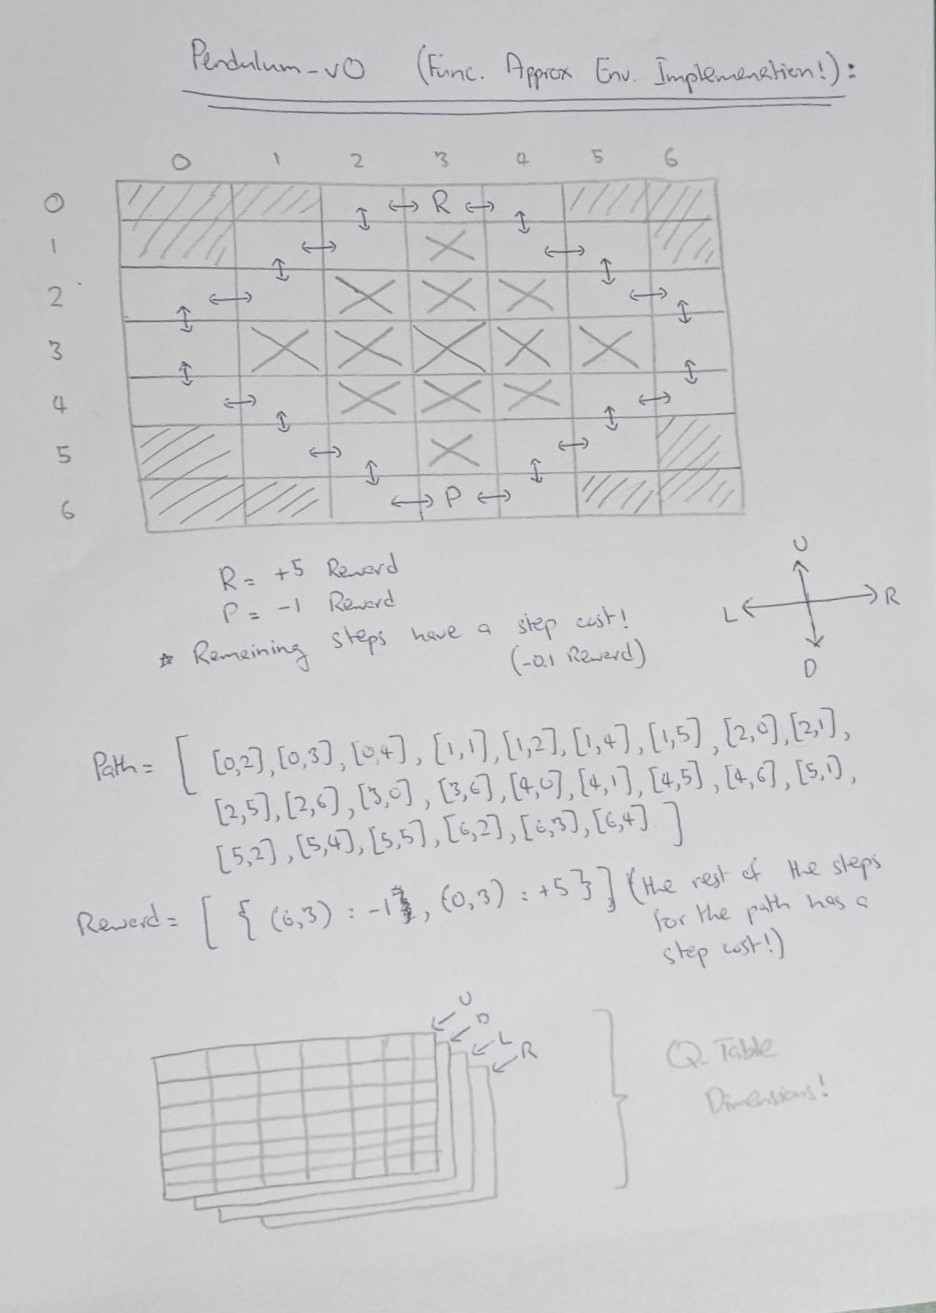

In [4]:
#Creating the Pendulum Environment...

pendulum = Grid(7, 7, (6, 3))
step_cost = -0.1

#Dictionary of the rewards assigned at every step of the path...
rewards = {
    (0, 3): 5,
    (0, 2): step_cost,
    (0, 4): step_cost,
    (1, 1): step_cost,
    (1, 2): step_cost,
    (1, 4): step_cost,
    (1, 5): step_cost,
    (2, 0): step_cost,
    (2, 1): step_cost,
    (2, 5): step_cost,
    (2, 6): step_cost,
    (3, 0): step_cost,
    (3, 6): step_cost,
    (4, 0): step_cost,
    (4, 1): step_cost,
    (4, 5): step_cost,
    (4, 6): step_cost,
    (5, 1): step_cost,
    (5, 2): step_cost,
    (5, 4): step_cost,
    (5, 5): step_cost,
    (6, 2): step_cost,
    (6, 4): step_cost,
    (6, 3): -1
    }

#Dictionary of the actions assigned at every step of the path...
actions = {
    (0, 2): ('D', 'R'),
    (0, 3): ('L', 'R'),
    (0, 4): ('L', 'D'),
    (1, 1): ('R', 'D'),
    (1, 2): ('L', 'U'),
    (1, 4): ('R', 'U'),
    (1, 5): ('L', 'D'),
    (2, 0): ('D', 'R'),
    (2, 1): ('L', 'U'),
    (2, 5): ('R', 'U'),
    (2, 6): ('L', 'D'),
    (3, 0): ('U', 'D'),
    (3, 6): ('U', 'D'),
    (4, 0): ('U', 'R'),
    (4, 1): ('L', 'D'),
    (4, 5): ('R', 'D'),
    (4, 6): ('L', 'U'),
    (5, 1): ('U', 'R'),
    (5, 2): ('L', 'D'),
    (5, 4): ('D', 'R'),
    (5, 5): ('L', 'U'),
    (6, 2): ('U', 'R'),
    (6, 3): ('L', 'R'),
    (6, 4): ('L', 'U'),
  }

#Setting our Grid with the rewards and actions...
pendulum.set(rewards, pendulum)

In [5]:
print("------------------------Rewards per state in the Environment------------------------\n")
print_values(rewards, pendulum)

------------------------Rewards per state in the Environment------------------------

---------------------------
 0.00 |
 0.00 |
-0.10 |
 5.00 |
-0.10 |
 0.00 |
 0.00 |

---------------------------
 0.00 |
-0.10 |
-0.10 |
 0.00 |
-0.10 |
-0.10 |
 0.00 |

---------------------------
-0.10 |
-0.10 |
 0.00 |
 0.00 |
 0.00 |
-0.10 |
-0.10 |

---------------------------
-0.10 |
 0.00 |
 0.00 |
 0.00 |
 0.00 |
 0.00 |
-0.10 |

---------------------------
-0.10 |
-0.10 |
 0.00 |
 0.00 |
 0.00 |
-0.10 |
-0.10 |

---------------------------
 0.00 |
-0.10 |
-0.10 |
 0.00 |
-0.10 |
-0.10 |
 0.00 |

---------------------------
 0.00 |
 0.00 |
-0.10 |
-1.00 |
-0.10 |
 0.00 |
 0.00 |



In [6]:
#Ensliting all the possible actions per state...

state = list(actions.keys())
possible_actions = list(actions.values())

print("------------------------Possible Actions at every step in the Environment------------------------\n")
for i in range(len(state)):
  print("{} | {}".format(state[i], possible_actions[i]))

------------------------Possible Actions at every step in the Environment------------------------

(0, 2) | ('D', 'R')
(0, 3) | ('L', 'R')
(0, 4) | ('L', 'D')
(1, 1) | ('R', 'D')
(1, 2) | ('L', 'U')
(1, 4) | ('R', 'U')
(1, 5) | ('L', 'D')
(2, 0) | ('D', 'R')
(2, 1) | ('L', 'U')
(2, 5) | ('R', 'U')
(2, 6) | ('L', 'D')
(3, 0) | ('U', 'D')
(3, 6) | ('U', 'D')
(4, 0) | ('U', 'R')
(4, 1) | ('L', 'D')
(4, 5) | ('R', 'D')
(4, 6) | ('L', 'U')
(5, 1) | ('U', 'R')
(5, 2) | ('L', 'D')
(5, 4) | ('D', 'R')
(5, 5) | ('L', 'U')
(6, 2) | ('U', 'R')
(6, 3) | ('L', 'R')
(6, 4) | ('L', 'U')


## Semi‐Gradient Sarsa(0)

We will create some basic functionalities for our algorithms while the agent learns in the environment.

In [14]:
# #Function for getting the actions of our Optimal Policy...

# def max_dict(d):
#   # returns the argmax (key) and max (value) from a dictionary
#   max_key = None
#   max_val = float('-inf')
#   for k, v in d.items():
#     if v > max_val:
#       max_val = v
#       max_key = k
#   return max_key, max_val

In [15]:
#Greedy/Exploration Function...

def epsilon_greedy_action(state, epsilon):
    #Exploration
    if np.random.uniform() < epsilon:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)  #Returns letter, not the index...
    #Expoitation
    else:
        _ , maxarg_a = actions[(state[0], state[1])]
        return maxarg_a                                 #Returns letter, not the index...

In [16]:
#Function for mapping actions into index...
def action_map(a):
  if a == 'U':
      i = 0
  elif a == 'D':
      i = 1
  elif a == 'R':
      i = 2
  elif a == 'L':
      i = 3
  return i

In [17]:
#Function to return reward with from a certain state with Grid Properties...

def step_function(s,a):
  # r = pendulum.move(a)
  i,j = s
  
  if s in actions.keys():
    if a == 'U':
      i -= 1
    elif a == 'D':
      i += 1
    elif a == 'R':
      j -= 1
    elif a == 'L':
      j += 1
    
    next_s = (i,j)
    if next_s in actions.keys():
      r = rewards.get(next_s, 0)
      #print(next_s,"-----",r)
      return next_s, r

    else:
      r = 0
      #print(next_s,"-----",r)

      #Undo the move...
      if a == 'U':
        i -= 1
      elif a == 'D':
        i += 1
      elif a == 'R':
        j -= 1
      elif a == 'L':
        j += 1
      #print("\nOut of bounds. Move Undone...")
      next_s = s
      return next_s, r

  else:
    r = 0
    #print("\nOut of bounds. Move Undone...")
    return s, r

#Running a small test for the function...
next_S, r = step_function((5,3),'D')
print(next_S, r)

(5, 3) 0


In [18]:
#Function for computing the gradient of the model...
def grad(Q, state, action):
    ci, cj = state
    gradient = np.zeros_like(Q)
    gradient = 1
    return gradient

For our Semi-Gradient SARSA(0), this is the psuedocode for us to implement:

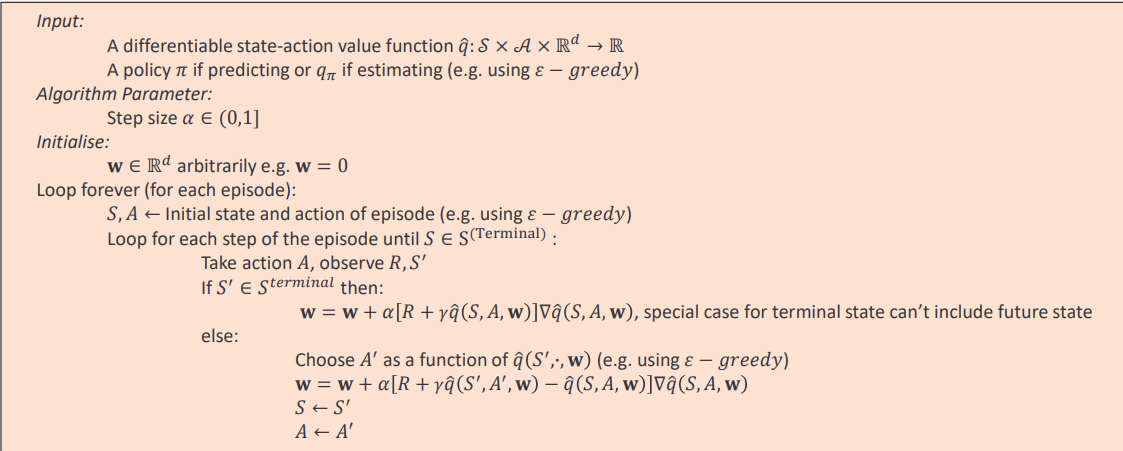

In [19]:
def semi_gradient_sarsa(num_episodes, alpha, gamma, epsilon):
    total_reward_per_episode = []
    average_reward_per_episode = []
    
    for i in range(num_episodes):

        #pendulum.set_state(s) / state = env.reset()      
        state = (6,3)    #Starting point of the Agent in the Environment...
        num_actions = len(ALL_POSSIBLE_ACTIONS)     # Number of Actions
        Q = np.zeros((7, 7, num_actions))           # Q-table Initialized
        Total_Q = np.zeros((7, 7, num_actions))
        total_reward = 0

        action = epsilon_greedy_action(state, epsilon)        
        for t in range(200):

            # Getting next state and reward...
            next_state, reward = step_function(state, action)

            #Getting dimensions of the current and next state in order to update the Q-Table...
            ci, cj = state
            ni, nj = next_state

            #Get the next action...
            next_action = epsilon_greedy_action(next_state, epsilon)
            
            #Mapping the current and next action...
            a = action_map(action)
            next_a = action_map(next_action)

            #Update the Q-Table...
            td_err = reward + gamma * Q[ni][nj][next_a] - Q[ci][cj][a]
            Q[ci][cj][a] += alpha * td_err * grad(Q[ci][cj][a], state, a)

            #Creating the total sum of the reward...
            total_reward += reward
            
            #Assign the new state and action and repeat...
            state = next_state
            action = next_action

        #Assigning the final state values in the final step...
        if i + 1 == 100:
            Total_Q += Q

        average_reward_per_episode.append(total_reward/200)
        total_reward_per_episode.append(total_reward)
        print("Episode --- [{}/100]  | Reward ---- {}".format(i + 1, total_reward))

    return total_reward_per_episode, average_reward_per_episode, Total_Q
      

## Semi‐Gradient TD(𝝀)

"Again, we are going to implement some of the basic functionalities for this algorithm as well: "

In [7]:
# Function for predicting the weights...
def predict(state, weights):
  i,j = state
  return np.dot(weights[i,j,:], np.ones(4))

In [8]:
#Function to return reward with from a certain state with Grid Properties...

def step_function(s,a):
  # r = pendulum.move(a)
  i,j = s
  
  if s in actions.keys():
    if a == 0:    #'U'
      i -= 1
    elif a == 1:  #'D'
      i += 1
    elif a == 2:  #'L'
      j -= 1
    elif a == 3:  #'R'
      j += 1
    
    next_s = (i,j)
    if next_s in actions.keys():
      r = rewards.get(next_s, 0)
      # print(next_s,"-----",r)
      return next_s, r

    else:
      r = 0
      #print(next_s,"-----",r)

      #Undo the move...
      if a == 0:    #'U'
        i += 1
      elif a == 1:  #'D'
        i -= 1
      elif a == 2:  #'L'
        j += 1
      elif a == 3:  #'R'
        j -= 1
      #print("\nOut of bounds. Move Undone...")
      next_s = s
      return next_s, r

  else:
    r = 0
    #print("\nOut of bounds. Move Undone...")
    return s, r

In [9]:
#Running a small test for the function...
next_S, r = step_function((0,2),3)
print(next_S, r)

(0, 3) 5


Likewise, for our second algorithm, this is how we will implement from the below pseudocode:

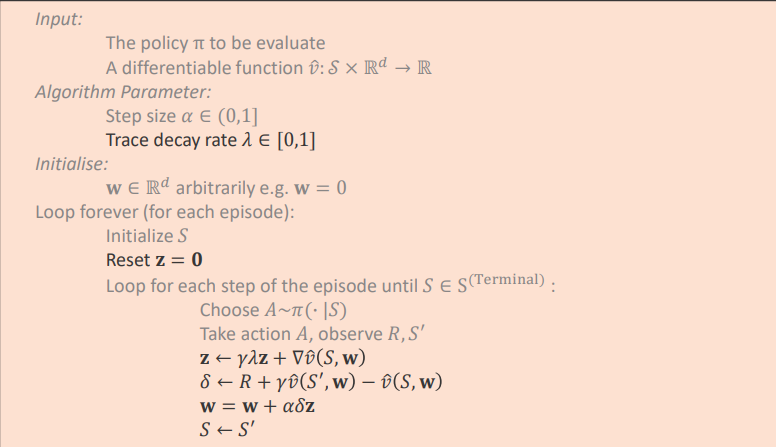

In [10]:
def semi_gradient_td_lambda(num_episodes, alpha, gamma, epsilon, lambda_):
        total_reward_per_episode = []
        average_reward_per_episode = []
    
        for i in range(num_episodes):
            #pendulum.set_state(s) / state = env.reset()      
            state = (6,3)    #Starting point of the Agent in the Environment...
            
            num_actions = len(ALL_POSSIBLE_ACTIONS)     # Number of Actions
            weights = np.zeros((7, 7, num_actions))     # Q-table/weights Initialized
            Total_Q = np.zeros((7, 7, num_actions))
            eligibility_trace = np.zeros((7,7,4))       # Resetting Eligibility Trace
            
            total_reward = 0
            # a = np.argmax(predict(state, weights))
            a = np.random.choice([2,3])                 # To kick-start the algorithm...
        
            for t in range(200):

                # Getting next state and reward...
                next_state, reward = step_function(state, a)       #env.step(action)

                #Getting dimensions of the current and next state in order to update the weights...
                ci, cj = state
                # ni, nj = next_state

                #Get the next action...
                next_a = predict(next_state, weights)
              
                #Computing TD Error (delta)...
                delta = reward + gamma * predict(next_state, weights) - predict(state, weights)
                
                #Updating the Q-Table/Weights...
                eligibility_trace *= lambda_
                eligibility_trace[ci,cj,int(a)] += 1
                weights += alpha * delta * eligibility_trace

                #Creating the total sum of the reward...
                total_reward += reward
                
                #Assign the new state and action and repeat...
                state = next_state
                a = next_a

            #Assigning the final state values in the final step...
            if i + 1 == 100:
                Total_Q += weights

            average_reward_per_episode.append(total_reward/200)
            total_reward_per_episode.append(total_reward)
            print("Episode --- [{}/100]  | Reward ---- {}".format(i + 1, total_reward))
        
        return total_reward_per_episode, average_reward_per_episode, Total_Q

## Comparison of Results

### SARSA(0) Results

In [20]:
trpe, sarsa_arpe, Total_Q = semi_gradient_sarsa(num_episodes, ALPHA, GAMMA, eps)
print("Average Reward after 100 Episodes: ",np.mean(trpe))

Episode --- [1/100]  | Reward ---- -5.3
Episode --- [2/100]  | Reward ---- -5.899999999999998
Episode --- [3/100]  | Reward ---- -1.6000000000000003
Episode --- [4/100]  | Reward ---- -1.6000000000000003
Episode --- [5/100]  | Reward ---- -13.29999999999997
Episode --- [6/100]  | Reward ---- -4.999999999999998
Episode --- [7/100]  | Reward ---- -6.8999999999999995
Episode --- [8/100]  | Reward ---- -1.0999999999999999
Episode --- [9/100]  | Reward ---- -4.6
Episode --- [10/100]  | Reward ---- -6.399999999999999
Episode --- [11/100]  | Reward ---- -3.9000000000000017
Episode --- [12/100]  | Reward ---- -6.599999999999999
Episode --- [13/100]  | Reward ---- -9.699999999999998
Episode --- [14/100]  | Reward ---- -4.4
Episode --- [15/100]  | Reward ---- -7.899999999999998
Episode --- [16/100]  | Reward ---- -10.099999999999998
Episode --- [17/100]  | Reward ---- -5.299999999999999
Episode --- [18/100]  | Reward ---- -4.4
Episode --- [19/100]  | Reward ---- -3.8000000000000007
Episode --- [

In [21]:
print("Average Reward per Episode: \n", sarsa_arpe)

Average Reward per Episode: 
 [-0.0265, -0.029499999999999988, -0.008000000000000002, -0.008000000000000002, -0.06649999999999985, -0.02499999999999999, -0.034499999999999996, -0.0055, -0.023, -0.031999999999999994, -0.019500000000000007, -0.032999999999999995, -0.04849999999999999, -0.022000000000000002, -0.039499999999999987, -0.05049999999999999, -0.026499999999999996, -0.022000000000000002, -0.019000000000000003, -0.03499999999999999, -0.016500000000000004, -0.023999999999999994, -0.03849999999999999, -0.039499999999999987, -0.03399999999999996, -0.07449999999999982, -0.026500000000000003, -0.021, -0.022, -0.0265, -0.0275, -0.030999999999999993, -0.022, -0.06149999999999985, -0.038499999999999986, -0.03399999999999999, -0.032999999999999995, -0.0265, -0.06499999999999985, -0.06599999999999998, -0.02, -0.043, -0.033999999999999996, -0.0245, -0.015500000000000003, -0.043999999999999984, -0.027499999999999983, -0.026999999999999996, -0.038499999999999986, -0.008, -0.02849999999999999,

In [22]:
print("Q-Table in the 100th Episode: \n", Total_Q)

Q-Table in the 100th Episode: 
 [[[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          

### TD(Lambda) Results

In [11]:
ALPHA = 0.1  # step size parameter
GAMMA = 1.0  # discount factor
eps = 0.1  # exploration rate
lambda_ = 0.5  # lambda parameter for eligibility trace

trpe_, td_arpe, Total_Q_ = semi_gradient_td_lambda(num_episodes, ALPHA, GAMMA, eps, lambda_)
print("Average Reward after 100 Episodes: ",np.mean(trpe_))

Episode --- [1/100]  | Reward ---- -0.2
Episode --- [2/100]  | Reward ---- -0.2
Episode --- [3/100]  | Reward ---- -0.2
Episode --- [4/100]  | Reward ---- -0.2
Episode --- [5/100]  | Reward ---- -0.2
Episode --- [6/100]  | Reward ---- -0.2
Episode --- [7/100]  | Reward ---- -0.2
Episode --- [8/100]  | Reward ---- -0.2
Episode --- [9/100]  | Reward ---- -0.2
Episode --- [10/100]  | Reward ---- -0.2
Episode --- [11/100]  | Reward ---- -0.2
Episode --- [12/100]  | Reward ---- -0.2
Episode --- [13/100]  | Reward ---- -0.2
Episode --- [14/100]  | Reward ---- -0.2
Episode --- [15/100]  | Reward ---- -0.2
Episode --- [16/100]  | Reward ---- -0.2
Episode --- [17/100]  | Reward ---- -0.2
Episode --- [18/100]  | Reward ---- -0.2
Episode --- [19/100]  | Reward ---- -0.2
Episode --- [20/100]  | Reward ---- -0.2
Episode --- [21/100]  | Reward ---- -0.2
Episode --- [22/100]  | Reward ---- -0.2
Episode --- [23/100]  | Reward ---- -0.2
Episode --- [24/100]  | Reward ---- -0.2
Episode --- [25/100]  | R

In [12]:
print("Average Reward per Episode: \n", td_arpe)

Average Reward per Episode: 
 [-0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001, -0.001]


In [13]:
print("Q-Table in the 100th Episode: \n", Total_Q_)

Q-Table in the 100th Episode: 
 [[[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]]

 [[ 0.     0.     0.     0.   ]
  [ 0.     0.     0.     0.   ]


### Semi-Gradient SARSA(0) vs Semi-Gradient TD(Lambda)

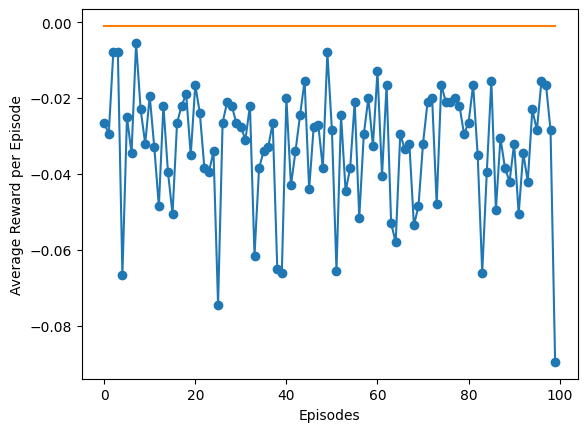

In [28]:
#Plotting the average rewards per episode...
x = [x for x in range(100)]
y1 = sarsa_arpe
y2 = td_arpe

plt.gca()  # shorthand for "get current axis"
plt.plot(x, y1, marker = 'o')
plt.plot(x, y2)
plt.xlabel("Episodes")
plt.ylabel("Average Reward per Episode")
plt.show()

## References

- https://www.gymlibrary.dev/environments/classic_control/pendulum/ 
- https://numpy.org/doc/stable/reference/ 
- https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/ 
- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
- Semi-Gradient SARSA: https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf (p. 152-154)
- Class Slides (Week 7, Week07_01_Function_Approximation1, Slides 9,14)
- https://therenegadecoder.com/code/how-to-plot-a-line-using-matplotlib-in-python/#:~:text=Perhaps%20the%20easiest%20way%20to%20generate%20a%20line,%5B2%2C%204%2C%206%2C%208%2C%2010%5D%20plt.plot%28x%2C%20y%29%20plt.show%28%29
- https://www.w3schools.com/python/matplotlib_markers.asp 